# 02 Baseline

In [1]:
import config
from utils import data_model
from utils.keras import losses
from utils.features01_dlib import FEATURES, TARGETS

import pandas as pd
import numpy as np
from tensorflow.contrib import keras

## Load data

In [2]:
data, imgs_left, imgs_right = data_model.load(
    config.PATH_DATA_FEATURES01_DLIB_AUGMENTED_NORM_CSV,
    config.PATH_DATA_FEATURES01_DLIB_AUGMENTED_NORM_IMGS_LEFT,
    config.PATH_DATA_FEATURES01_DLIB_AUGMENTED_NORM_IMGS_RIGHT
)

In [3]:
data.head()

,eye_left_y,eye_left_x,face_height,face_width,eye_left_height,face_x,eye_right_x,y,x,glasses,eye_right_width,face_y,eye_left_image,eye_right_image,eye_right_height,eye_left_width,eye_right_y
0,0.454167,-0.162500,0.447222,0.503125,0.077778,-0.232813,0.051562,0.585938,-0.998538,False,0.171875,0.384722,1c322a8bbd645b20da263dd342dc20ce_eye_left_0.jpg,1c322a8bbd645b20da263dd342dc20ce_eye_right_0.jpg,0.081944,0.171875,0.456944
1,0.456944,-0.160937,0.447222,0.503125,0.059722,-0.232813,0.050000,0.585938,-0.998538,False,0.175000,0.384722,1c322a8bbd645b20da263dd342dc20ce_eye_left_1.jpg,1c322a8bbd645b20da263dd342dc20ce_eye_right_1.jpg,0.070833,0.165625,0.459722
2,0.454167,-0.160937,0.447222,0.503125,0.075000,-0.232813,0.050000,0.585938,-0.998538,False,0.171875,0.384722,1c322a8bbd645b20da263dd342dc20ce_eye_left_2.jpg,1c322a8bbd645b20da263dd342dc20ce_eye_right_2.jpg,0.077778,0.171875,0.458333
3,0.455556,-0.157813,0.447222,0.503125,0.066667,-0.232813,0.054688,0.585938,-0.998538,False,0.168750,0.384722,1c322a8bbd645b20da263dd342dc20ce_eye_left_3.jpg,1c322a8bbd645b20da263dd342dc20ce_eye_right_3.jpg,0.070833,0.162500,0.461111
4,0.454167,-0.156250,0.447222,0.503125,0.070833,-0.232813,0.054688,0.585938,-0.998538,False,0.165625,0.384722,1c322a8bbd645b20da263dd342dc20ce_eye_left_4.jpg,1c322a8bbd645b20da263dd342dc20ce_eye_right_4.jpg,0.077778,0.162500,0.456944


## Split data

In [4]:
(
    (train_data, train_imgs_left, train_imgs_right),
    (validation_data, validation_imgs_left, validation_imgs_right),
    (test_data, test_imgs_left, test_imgs_right)
) = data_model.split(
    data, imgs_left, imgs_right,
    train_size=0.95,
    validation_size=0.95,
    random_state=42
)

In [5]:
print("Train length: {}".format(len(train_data)))
print("Validation length: {}".format(len(validation_data)))
print("Test length: {}".format(len(test_data)))

Train length: 43334
Validation length: 2281
Test length: 2401


## Model

### Architecture

![](img/models/02-baseline.png)

In [6]:
def get_model():

    # Inputs
    left_imgs = keras.layers.Input(shape=(20,30), name='left_imgs', dtype='float32')
    right_imgs = keras.layers.Input(shape=(20,30), name='right_imgs', dtype='float32')
    features = keras.layers.Input(shape=(len(FEATURES),), name='features', dtype='float32')
    # Flatten images & concatenate
    flat_input = keras.layers.Concatenate()([
        keras.layers.Flatten()(left_imgs),
        keras.layers.Flatten()(right_imgs),
        features
    ])
    # Dense
    d_1 = keras.layers.Dense(1024, activation=keras.activations.relu)(flat_input)
    d_2 = keras.layers.Dense(512, activation=keras.activations.relu)(d_1)
    d_3 = keras.layers.Dense(128, activation=keras.activations.relu)(d_2)
    d_4 = keras.layers.Dense(2)(d_3)
    # Model
    model = keras.models.Model(
        inputs=[left_imgs, right_imgs, features],
        outputs=[d_4]
    )
    return model

### Parameters

In [7]:
MODEL_NAME = 'baseline-08'

EPOCHS = 150
BATCH_SIZE = 128
LEARNING_RATE = 0.0005
DECAY = 0.00001

In [ ]:
model = get_model()

model.compile(
    loss=losses.euclidean,
    optimizer=keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=DECAY)
)

print("Parameters to adjust: {}".format(
    np.sum([keras.backend.count_params(p) for p in set(model.trainable_weights)])
))

### Train

In [ ]:
model.fit(
    x={
        'left_imgs':train_imgs_left,
        'right_imgs': train_imgs_right,
        'features': train_data[FEATURES].as_matrix()
    },
    y=train_data[TARGETS].as_matrix(),
    validation_data=(
        {
            'left_imgs': validation_imgs_left,
            'right_imgs': validation_imgs_right,
            'features': validation_data[FEATURES].as_matrix()
        },
        validation_data[TARGETS].as_matrix()
    ),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1, callbacks=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0
)

In [ ]:
model.save(config.PATH_MODELS_KERAS+MODEL_NAME)

### Test

In [8]:
model_test = keras.models.load_model(
    filepath=config.PATH_MODELS_KERAS+MODEL_NAME,
    custom_objects={
        "euclidean":losses.euclidean
    }
)

In [9]:
model_test.evaluate(
    x={
        'left_imgs':test_imgs_left,
        'right_imgs': test_imgs_right,
        'features': test_data[FEATURES].as_matrix()
    },
    y=test_data[TARGETS].as_matrix(),
    batch_size=1,
    verbose=1, sample_weight=None
)

2386/2401 [============================>.] - ETA: 0s

0.10026176797357178

### Results


| Name | Epochs | Batch Size | Learning rate | Decay | Train | Validation | Test |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
| baseline-08 | 150 | 128| 0.0005 | 0.00001 | 0.0239 | 0.0983 | 0.1003 |

### Errors

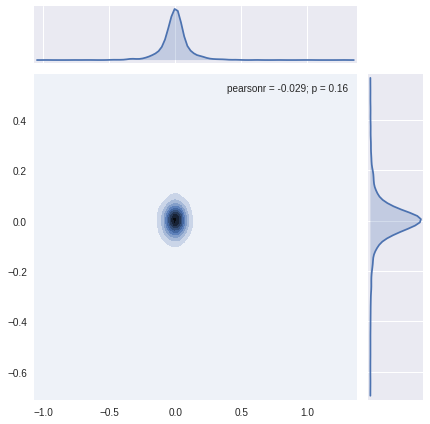

In [10]:
import seaborn as sns
%matplotlib inline


predictions = model_test.predict(
    x={
        'left_imgs':test_imgs_left,
        'right_imgs': test_imgs_right,
        'features': test_data[FEATURES].as_matrix()
    }
)
errors = test_data[TARGETS].as_matrix()-predictions
sns.jointplot(x=errors[:,0], y=errors[:,1], kind="kde")